<a href="https://colab.research.google.com/github/trnhatnam/Projets_IA/blob/main/fruits_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dataset from kaggle

In [ ]:
!pip install kaggle  &> /dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download sshikamaru/fruit-recognition

Dataset URL: https://www.kaggle.com/datasets/sshikamaru/fruit-recognition
License(s): other
 76% 78.0M/102M [00:00<00:00, 210MB/s]
100% 102M/102M [00:00<00:00, 208MB/s] 


In [ ]:
!unzip fruit-recognition.zip &> /dev/null

# Create a Pytorch dataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
%matplotlib inline

In [ ]:
path_to_train = '/content/train/train'
path_to_test = '/content/test/test'

In [ ]:
class FruitsTrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.categories = []

        # Parcourir les dossiers train et test
        for split in [path_to_train]:
            split_dir = os.path.join(root_dir, split)
            for category in os.listdir(split_dir):
                category_dir = os.path.join(split_dir, category)
                for img in os.listdir(category_dir):
                    img_path = os.path.join(category_dir, img)
                    self.image_paths.append(img_path)
                    self.categories.append(category)

        # Création d'un dictionnaire pour suivre les labels
        d = {}
        i = 0
        self.labels = []
        for cat in self.categories:
          if cat not in d:
            d[cat] = i
            i += 1
          self.labels.append(d[cat])


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transformation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

fruits_train_dataset = FruitsTrainDataset('drive', transform=transformation)


In [ ]:
# Separate into train/test sets because we just want to create a simple model (we don't do the competition) so we only use the train dataset for now
# Split the dataset into train and test sets
train_size = int(0.8 * len(fruits_train_dataset))  # 80% for training
test_size = len(fruits_train_dataset) - train_size
train_dataset, test_dataset = random_split(fruits_train_dataset, [train_size, test_size])

# Create DataLoaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

tensor(24)


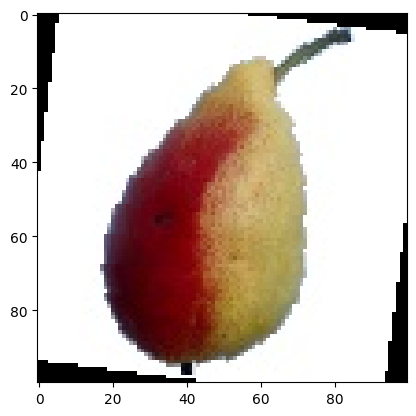

In [ ]:
for i,(x, y) in enumerate(test_loader):
  plt.imshow(x[5].permute(1,2,0))
  print(y[0])
  break

# CNN

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # conv layer
    self.conv1 = nn.Conv2d(3, 12, 3, 1, padding=1)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(12, 32, 3, 1, padding=1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.pool3 = nn.MaxPool2d(2, 2)

    # fully connected
    self.layer1 = nn.Linear(12*12*64, 1000)
    self.layer2 = nn.Linear(1000, 100)
    self.layer3 = nn.Linear(100, 33)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)

    x = x.view(-1, 12*12*64)
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = self.layer3(x)

    return F.log_softmax(x, dim=1)

In [ ]:
model = CNN()
optimizer= optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 5
train_losses = []
test_losses = []
train_correct = np.zeros(epochs)
test_correct = np.zeros(epochs)

for i in range(epochs):
  #train
  for batch, (X_train ,y_train) in enumerate(train_loader):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    train_correct[i] += (torch.max(y_pred,1)[1] == y_train).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (batch % 100 == 0):
      print(f"Epoch {i} Batch {batch} Loss {loss.item()}")

    train_losses.append(loss)

  #test
  with torch.no_grad():
    for batch, (X_test, y_test) in enumerate(test_loader):
      y_eval = model.forward(X_test)
      loss = criterion(y_eval, y_test)
      test_correct[i] += (torch.max(y_eval,1)[1] == y_test).sum()

      test_losses.append(loss)

Epoch 0 Batch 0 Loss 3.5011322498321533
Epoch 0 Batch 100 Loss 2.1652073860168457
Epoch 0 Batch 200 Loss 1.0096889734268188
Epoch 0 Batch 300 Loss 1.5823755264282227
Epoch 0 Batch 400 Loss 1.409754753112793
Epoch 1 Batch 0 Loss 1.4394681453704834
Epoch 1 Batch 100 Loss 1.6566733121871948
Epoch 1 Batch 200 Loss 0.9226163625717163
Epoch 1 Batch 300 Loss 0.5889682769775391
Epoch 1 Batch 400 Loss 0.4688500165939331
Epoch 2 Batch 0 Loss 0.7070069909095764
Epoch 2 Batch 100 Loss 0.6732553243637085
Epoch 2 Batch 200 Loss 0.5485347509384155
Epoch 2 Batch 300 Loss 0.5454075336456299
Epoch 2 Batch 400 Loss 0.6253607869148254
Epoch 3 Batch 0 Loss 0.34814631938934326
Epoch 3 Batch 100 Loss 0.30960193276405334
Epoch 3 Batch 200 Loss 0.7333235740661621
Epoch 3 Batch 300 Loss 0.37864822149276733
Epoch 3 Batch 400 Loss 0.23385891318321228
Epoch 4 Batch 0 Loss 0.1596243679523468
Epoch 4 Batch 100 Loss 0.48976269364356995
Epoch 4 Batch 200 Loss 0.584083616733551
Epoch 4 Batch 300 Loss 0.2623885869979858

In [ ]:
torch.save(model.state_dict(), "cnn_fruits.pt")

In [ ]:
train_losses = [elem.detach().numpy() for elem in train_losses]

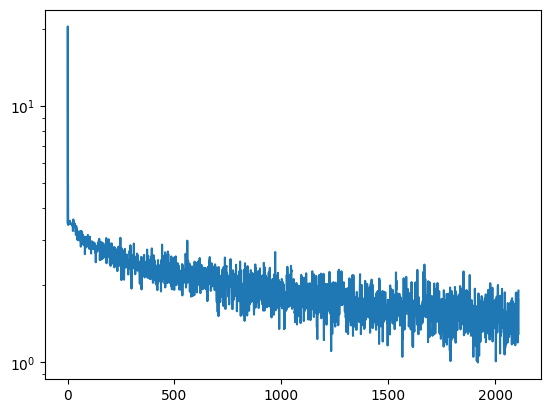

In [ ]:

plt.semilogy(train_losses)

In [ ]:
test_losses = [elem.detach().numpy() for elem in test_losses]

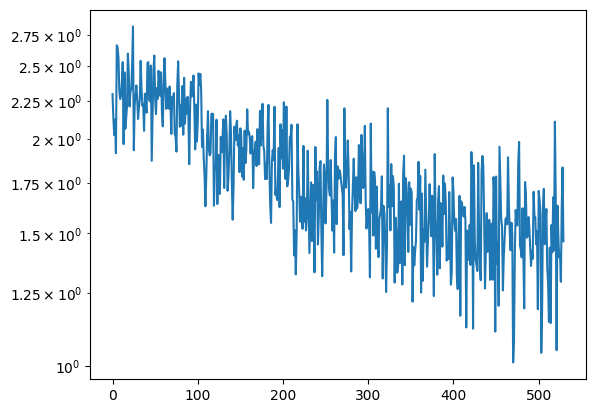

In [ ]:
plt.semilogy(test_losses)

tensor(24)


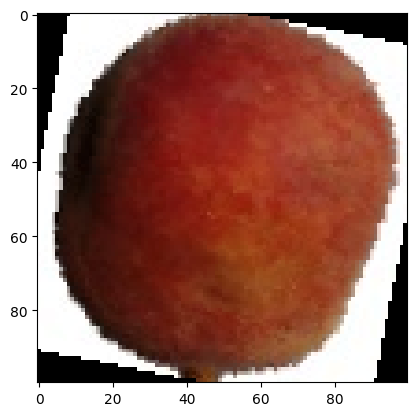

In [ ]:
# 1 test

for index, (X_test_1, y_test_1) in enumerate(test_loader):
  plt.imshow(X_test_1[8].permute(1,2,0))
  print(y_test_1[8])
  break

In [ ]:
# see the category
label_to_look = np.where(np.array(fruits_train_dataset.labels) == 24)[0][0]
corr_category = fruits_train_dataset.categories[label_to_look]
corr_category

'Peach'

In [ ]:
with torch.no_grad():
  for index, (X_test_1, y_test_1) in enumerate(test_loader):
    y_pred = model(X_test_1[10])
    print(X_test_1[10].shape)
    print(np.argmax(y_pred))
    break

torch.Size([3, 100, 100])
tensor(32)
